In [22]:
import torch
import torch.nn as nn
from tqdm import tqdm
from torch.optim import SGD as torch_SGD
from model_2 import Model
import matplotlib.pyplot as plt
import torchvision.transforms as T 
from PIL import Image
device =  'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

model = Model()

path_train = '../data/train_data.pkl'
path_val = '../data/val_data.pkl'

noisy_imgs_1, noisy_imgs_2 = torch.load(path_train)
noisy_imgs_1 = noisy_imgs_1[0:1000].to(device).float()/256
noisy_imgs_2 = noisy_imgs_2[0:1000].to(device).float()/256

noisy_imgs , clean_imgs = torch.load(path_val)
noisy_imgs = noisy_imgs[0:10].to(device).float()/256
clean_imgs = clean_imgs[0:10].to(device).float()/256


cuda


In [23]:
lr = 1e-2
k = 3
m= 32
in_ch = 3
stride = 2
padding = 1
output_padding =1
device = 'cuda'
bs = 2
batch_size = 100

inp_1 = noisy_imgs_1.clone().type(torch.float).split(batch_size)
inp_2 = noisy_imgs_1.clone().type(torch.float).split(batch_size)
tar_1 = noisy_imgs_2.clone().type(torch.float).split(batch_size)
tar_2 = noisy_imgs_2.clone().type(torch.float).split(batch_size)
inp_val_1 = noisy_imgs.clone()
inp_val_2 = noisy_imgs.clone()
tar_val_1 = clean_imgs.clone()
tar_val_2 = clean_imgs.clone()

nn_conv1 = nn.Conv2d(in_ch,m, kernel_size = (k,k), stride=stride, padding=padding, device=device)
nn_conv2 = nn.Conv2d(m, 2*m, kernel_size = (k,k), stride=stride, padding=padding,device=device)
nn_tconv1 = nn.ConvTranspose2d(2*m, m, kernel_size = (k,k), stride=stride, padding=padding,device=device, output_padding=output_padding)
nn_tconv2 = nn.ConvTranspose2d(m, in_ch, kernel_size = (k,k), stride=stride, padding=padding,device=device, output_padding=output_padding)    

torch_model = nn.Sequential(nn_conv1,nn.ReLU(),
    nn_conv2,nn.ReLU(),
    nn_tconv1,nn.ReLU(),
    nn_tconv2,nn.Sigmoid()
    )

torch_optimizer = torch_SGD(torch_model.parameters(), lr = lr)
torch_mse = nn.MSELoss()

for e in tqdm(range(10)):
    for i in range(len(inp_1)):
        
        torch_optimizer.zero_grad()
        torch_out = torch_model(inp_1[i])
        transform = T.ToPILImage()        
        torch_loss = torch_mse(torch_out, tar_1[i])
        torch_loss.backward()
        torch_optimizer.step()

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 20.27it/s]


tensor(0.4854, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.5566, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.4193, device='cuda:0', grad_fn=<MinBackward1>)


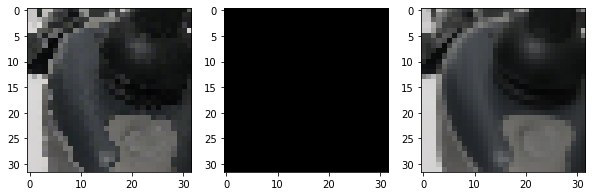

In [41]:
torch_out = torch_model(inp_val_1)

print(torch_out[0].mean(), torch_out[0].max(), torch_out[0].min())

transform = T.ToPILImage()
plt.figure(figsize = [10, 5])
plt.subplot(1, 3,1)
plt.imshow(transform(inp_val_1[5]));
plt.subplot(1, 3,2)
plt.imshow(transform(torch_out[5]/256));
plt.subplot(1, 3,3)
plt.imshow(transform(tar_val_1[5]));

In [33]:
inp_1 = noisy_imgs_1.clone().type(torch.float)
tar_1 = noisy_imgs_2.clone().type(torch.float)
inp_val_1 = noisy_imgs.clone()
tar_val_1 = clean_imgs.clone()

In [35]:
model.optimizer.lr = 1e-3
model.optimizer.set_momentum(0.1)
model.train(inp_1, tar_1, 100)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:48<00:00,  2.06it/s]


In [36]:
out = model.predict(inp_val_1)

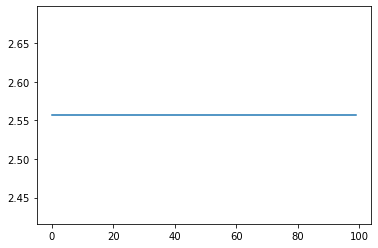

In [5]:
import matplotlib.pyplot as plt
plt.plot(model.loss_train.cpu())

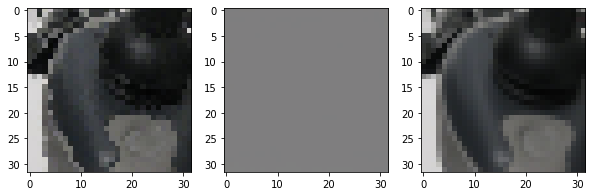

In [39]:
transform = T.ToPILImage()
plt.figure(figsize = [10, 5])
plt.subplot(1, 3,1)
plt.imshow(transform(inp_val_1[5]));
plt.subplot(1, 3,2)
plt.imshow(transform(out[5]/256));
plt.subplot(1, 3,3)
plt.imshow(transform(tar_val_1[5]));